In [5]:
!pip install geopy
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
  Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
You should consider upgrading via the '/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/Compiler/gcccore/11.2.0/python/3.9.6/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
from matplotlib.ticker import FuncFormatter

### Read, Data preprocessing

In [2]:
df = pd.read_csv('train.csv', index_col=0)

In [3]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# CUDA name
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-16GB'

In [5]:
# no nan values
df.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
# no missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458644 entries, id2875421 to id1209952
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [7]:
for col in df.columns:
    print(col, df[col].dtype)

vendor_id int64
pickup_datetime object
dropoff_datetime object
passenger_count int64
pickup_longitude float64
pickup_latitude float64
dropoff_longitude float64
dropoff_latitude float64
store_and_fwd_flag object
trip_duration int64


In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_time'] = df['pickup_datetime'].dt.time
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df['dropoff_date'] = df['dropoff_datetime'].dt.date
df['dropoff_time'] = df['dropoff_datetime'].dt.time



In [9]:
def calculate_distance(row):
    coord1 = (row['pickup_latitude'], row['pickup_longitude'])
    coord2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(coord1, coord2).meters

df['distance'] = df.apply(calculate_distance , axis=1)

In [10]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,distance
id,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17:24:55,2016-03-14,17:32:30,1502.171837
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,00:43:35,2016-06-12,00:54:38,1808.659969
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11:35:24,2016-01-19,12:10:48,6379.687175
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19:32:31,2016-04-06,19:39:40,1483.632481
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13:30:55,2016-03-26,13:38:10,1187.037659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13:31:04,2016-04-08,13:44:02,1227.089623
id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,07:35:15,2016-01-10,07:46:10,6046.211843
id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,06:57:41,2016-04-22,07:10:25,7821.531849


In [11]:
df['avg_velocity'] = df['distance']/df['trip_duration']

In [12]:
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,distance,avg_velocity
id,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17:24:55,2016-03-14,17:32:30,1502.171837,3.301477
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,00:43:35,2016-06-12,00:54:38,1808.659969,2.727994
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11:35:24,2016-01-19,12:10:48,6379.687175,3.003619
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19:32:31,2016-04-06,19:39:40,1483.632481,3.458351
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13:30:55,2016-03-26,13:38:10,1187.037659,2.728822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13:31:04,2016-04-08,13:44:02,1227.089623,1.577236
id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,07:35:15,2016-01-10,07:46:10,6046.211843,9.230858
id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,06:57:41,2016-04-22,07:10:25,7821.531849,10.237607


In [13]:
# cols_to_drop = ['pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag']
# df.drop(columns=cols_to_drop, inplace=True, axis =1)

### Data Visualization

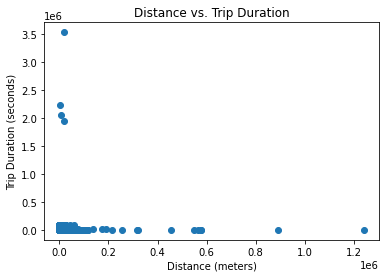

In [14]:
plt.scatter(df['distance'], df['trip_duration'])
plt.title('Distance vs. Trip Duration')
plt.xlabel('Distance (meters)')
plt.ylabel('Trip Duration (seconds)')
plt.show()

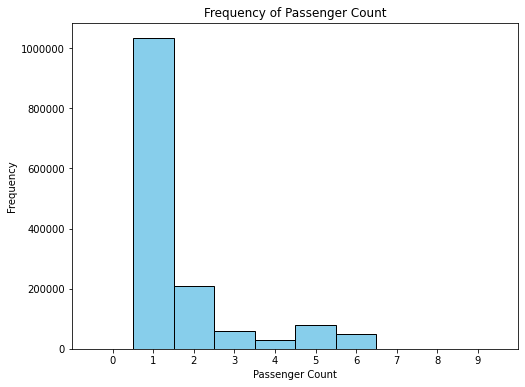

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(df['passenger_count'], bins=range(min(df['passenger_count']), max(df['passenger_count']) + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Frequency of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

# Customize x-axis to show each passenger count value
plt.xticks(range(min(df['passenger_count']), max(df['passenger_count']) + 1))
plt.ticklabel_format(style='plain', axis='y')

plt.show()

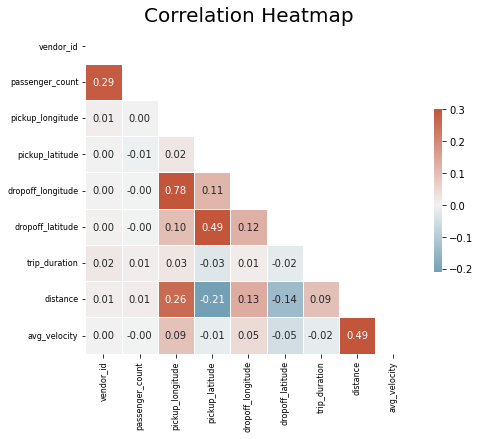

In [16]:
cols_corr = ['vendor_id','passenger_count' ,'pickup_longitude', 'pickup_latitude',	'dropoff_longitude'	,'dropoff_latitude',	'trip_duration',	'distance', 	'avg_velocity']
corr_df = df[cols_corr]
corr_matrix = corr_df.corr()
plt.figure(figsize=(8, 6))  
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f", annot_kws={"size": 10})

plt.title('Correlation Heatmap', fontsize=20)
plt.xticks(fontsize=8)  
plt.yticks(fontsize=8)
plt.show()

In [17]:
# df.drop(columns='id', inplace=True)
# df

In [18]:
cols_corr = ['vendor_id','passenger_count' ,'pickup_longitude', 'pickup_latitude',	'dropoff_longitude'	,'dropoff_latitude',	'trip_duration',	'distance', 	'avg_velocity']
corr_df = df[cols_corr]
corr_df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_velocity
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.008115,0.002110
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.010307,-0.001421
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.259976,0.090033
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,-0.210452,-0.014366
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,0.134103,0.046361
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,-0.142165,-0.049629
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.094789,-0.018477
distance,0.008115,0.010307,0.259976,-0.210452,0.134103,-0.142165,0.094789,1.000000,0.485316
avg_velocity,0.002110,-0.001421,0.090033,-0.014366,0.046361,-0.049629,-0.018477,0.485316,1.000000


In [19]:
y1 = corr_df[['distance']]
cols = ['vendor_id','passenger_count' ,'pickup_longitude', 'pickup_latitude',	'dropoff_longitude'	,'dropoff_latitude',	'trip_duration',	'avg_velocity']
X1 = corr_df[cols]

In [20]:
# corr_df = pd.concat([corr_df, y], axis=1)

### Splitting Dataset into X, Y and Training, Validation and Testing

In [21]:
X1

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,avg_velocity
id,,,,,,,,
id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3.301477
id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,663,2.727994
id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,3.003619
id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,429,3.458351
id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,435,2.728822
...,...,...,...,...,...,...,...,...
id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,778,1.577236
id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,655,9.230858
id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,764,10.237607


In [22]:
y1

,distance
id,
id2875421,1502.171837
id2377394,1808.659969
id3858529,6379.687175
id3504673,1483.632481
id2181028,1187.037659
...,...
id2376096,1227.089623
id1049543,6046.211843
id2304944,7821.531849


In [23]:
scaler = StandardScaler()
scaler.fit(X1)
X = scaler.transform(X1)

scaler.fit(y1)
y = scaler.transform(y1)

# scaled_X = pd.DataFrame(scaled_data, columns=X.columns)

In [24]:
X = X
X.shape

(1458644, 8)

In [25]:
y = y
y.shape

(1458644, 1)

In [26]:
# # Split the data into train and test sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split the train set further into train and validation sets (60% train, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

### Defining RNN Model

In [58]:
class JoinXY(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
#         self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)  
        out = out.squeeze(1)  
        out = self.fc(out)  

        return out

dataset = JoinXY(X, y)
dataset


In [60]:
print(RNNModel(input_size, hidden_size, num_layers, output_size))

RNNModel(
  (rnn): RNN(8, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [28]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

### Training, Validation, Testing and Printing Main Statistics with Optimization Technique

In [38]:
def training(model, criterion, optimizer):
    labels_test = []
    predictions_test = []

    training_loss = []
    validation_loss = []
    testing_loss = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
#             running_loss = 0.0
            optimizer.zero_grad() 
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            outputs = model(inputs)
    #         outputs = outputs.squeeze(-1)  
            loss = criterion(outputs, labels.float())
    #         labels = labels.flatten()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
            training_loss.append(running_loss)
        print(f"Training Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}")

        model.eval()  
        running_val_loss = 0.0

        for inputs, labels in valloader:
#             running_val_loss = 0.0
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_val_loss += loss.item()
            validation_loss.append(running_val_loss)
            
#             labels_test.append(labels.cpu().detach().numpy())
#             predictions_test.append(outputs.cpu().detach().numpy())
        print(f"Val Epoch {epoch+1}/{num_epochs}, Loss: {running_val_loss/len(valloader)}")

        model.eval()  
        running_test_loss = 0.0

        for inputs, labels in testloader:
#             running_test_loss = 0.0
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            running_test_loss += loss.item()
            labels_test.append(labels.cpu().detach().numpy())
            predictions_test.append(outputs.cpu().detach().numpy())
            

    #     avg_test_loss = running_test_loss / len(testloader)
            testing_loss.append(running_test_loss)
    
        print(f"Test Epoch {epoch+1}/{num_epochs}, Loss: {running_test_loss/len(testloader)}")
    labels_test = np.concatenate(labels_test, axis=0)
    predictions_test = np.concatenate(predictions_test, axis=0)

    return labels_test, predictions_test, training_loss, validation_loss, testing_loss
    

In [41]:
def LossesPlot(training_loss, validation_loss, testing_loss):
    max_y = max([max(training_loss), max(validation_loss), max(testing_loss)])
    plt.figure(figsize=(6, 4))
    plt.plot(training_loss, label='Training Loss',  linestyle='-', color='blue')
    plt.plot(validation_loss, label='Validation Loss',  linestyle='-', color='green')
    plt.plot(testing_loss, label='Test Loss',  linestyle='-', color='red')
    plt.xlim([0.0, num_epochs])
    plt.ylim([0.0, 1.0])

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()

    plt.show()

In [42]:
def eval_metrics(labels, predictions):
    # R2 Score
    r2 = r2_score(labels, predictions)
    print(f"R2 Score: {r2}")
    
    # MAE(Mean Absolute Error), MSE(Mean Squared Error), RMSE(Root Mean Squared Error)
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)
    rmse = np.sqrt(mse) 
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    

### Base Model

In [45]:
input_size = 8
hidden_size = 64  
num_layers = 4  
output_size = 1  
num_epochs = 10

model_m1 = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion_m1 = nn.MSELoss()
optimizer_m1 = optim.Adam(model_m1.parameters(), lr=0.0015)

labels_test, predictions_test, training_loss, validation_loss, testing_loss = training(model = model_m1, criterion =criterion_m1, optimizer = optimizer_m1) 
# LossesPlot(training_loss,
#            validation_loss, testing_loss)
eval_metrics(labels_test, predictions_test)

Training Epoch 1/10, Loss: 0.13399789538450407
Val Epoch 1/10, Loss: 0.38527779015185354
Test Epoch 1/10, Loss: 0.08175133813581718
Training Epoch 2/10, Loss: 0.11487348025162811
Val Epoch 2/10, Loss: 0.3620663529248531
Test Epoch 2/10, Loss: 0.07868529919680109
Training Epoch 3/10, Loss: 0.1123365145503789
Val Epoch 3/10, Loss: 0.3947794256434888
Test Epoch 3/10, Loss: 0.08410609665671491
Training Epoch 4/10, Loss: 0.11579460021983524
Val Epoch 4/10, Loss: 0.44806781327218453
Test Epoch 4/10, Loss: 0.15429329597065675
Training Epoch 5/10, Loss: 0.10948194698269409
Val Epoch 5/10, Loss: 0.34300376125400256
Test Epoch 5/10, Loss: 0.0799863450545488
Training Epoch 6/10, Loss: 0.11876464427579322
Val Epoch 6/10, Loss: 0.5314985077831438
Test Epoch 6/10, Loss: 0.2304511400984023
Training Epoch 7/10, Loss: 0.11652376314959263
Val Epoch 7/10, Loss: 0.4149537457885402
Test Epoch 7/10, Loss: 0.10226472600167887
Training Epoch 8/10, Loss: 0.10964179509756379
Val Epoch 8/10, Loss: 0.357361835237

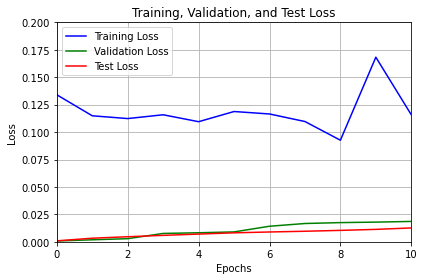

In [51]:
LossesPlot(training_loss,validation_loss, testing_loss)

### Base Model + L2 Regularization

In [46]:
input_size = 8 
hidden_size = 64  
num_layers = 4  
output_size = 1 
num_epochs = 10

model_m2 = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
# Regularization (L2)
l2_reg = 0.001

criterion_m2 = nn.MSELoss()
optimizer_m2 = optim.Adam(model_m2.parameters(), lr=0.001, weight_decay=l2_reg)

labels_test, predictions_test, training_loss, validation_loss, testing_loss = training(model = model_m2, criterion =criterion_m2, optimizer = optimizer_m2) 
eval_metrics(labels_test, predictions_test)


Training Epoch 1/10, Loss: 0.13484574806180222
Val Epoch 1/10, Loss: 0.3988142944258892
Test Epoch 1/10, Loss: 0.08219337123800452
Training Epoch 2/10, Loss: 0.12103486403205571
Val Epoch 2/10, Loss: 0.39858566963756153
Test Epoch 2/10, Loss: 0.08330478859711839
Training Epoch 3/10, Loss: 0.11546389624622247
Val Epoch 3/10, Loss: 0.3874781279310935
Test Epoch 3/10, Loss: 0.08507082714099189
Training Epoch 4/10, Loss: 0.11911868341052542
Val Epoch 4/10, Loss: 0.3893810505930413
Test Epoch 4/10, Loss: 0.08519156757752994
Training Epoch 5/10, Loss: 0.11921181330109251
Val Epoch 5/10, Loss: 0.39029977310325253
Test Epoch 5/10, Loss: 0.08131718261952385
Training Epoch 6/10, Loss: 0.10689096604920681
Val Epoch 6/10, Loss: 0.37737677112946566
Test Epoch 6/10, Loss: 0.07449891606260513
Training Epoch 7/10, Loss: 0.11028801122860081
Val Epoch 7/10, Loss: 0.38017185445405455
Test Epoch 7/10, Loss: 0.0775271786430496
Training Epoch 8/10, Loss: 0.10520237342836991
Val Epoch 8/10, Loss: 0.371508550

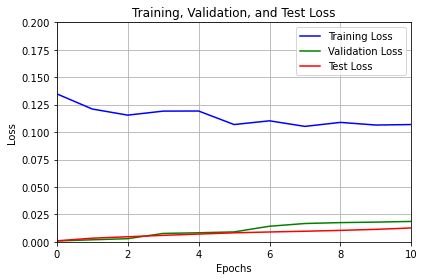

In [54]:
LossesPlot(training_loss, validation_loss, testing_loss)

### Saving Model Weights

In [48]:
torch.save(model_m2.state_dict(), 'ngupta22_kchavan_assignment1_part_3.h5')

In [55]:
# Save model weights with second best accuracy
torch.save(model_m1.state_dict(), 'ngupta22_kchavan_assignment1_part_3_model1.h5')

#### As we were getting R2 score above 90%, according to Piazza post https://piazza.com/class/lrsnr0odgns51m/post/138_f29 , we applied only 1 optimization technique. 